# Solution Planning (IOT)

## Input

* A empresa conta uma frota média de caminhões para realizar entregas por todo país, porém nos últimos 3 anos vem percebendo um grande aumento nos gastos referentes à manutenção do sistema de ar de seus veículos, mesmo mantendo o tamanho de sua frota constante.

## Output

 * Diminuir os custos de manutenção deste sistema nos caminhões. 


## Tasks

* Objetivo: Montar uma análise utilizando técnicas de ciência de dados para validar a prova de conceito proposta. Ao final, montar uma apresentação para como sendo para a diretoria executiva apresentando os resultados encontrados. O que será avaliado:
 - workflow de ciência de dados para construir sua solução
 - impacto do negócio na solução desenvolvida
 - qualidade da apresentação dos resultados


# 0.0 IMPORTS

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno

import matplotlib.pyplot as plt


from IPython.display         import HTML

from imblearn.combine import SMOTETomek 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_validate, cross_val_score, RandomizedSearchCV

# metrics
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve

from sklearn  import model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
import pickle


# models
from sklearn.linear_model  import LogisticRegression

## 0.2 Helper Function

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

import warnings
warnings.filterwarnings('ignore')


# Gráficos para análise univariada

def uni_analysis(data, feature_name):
    
      if feature_name != 'class':

                fig,ax = plt.subplots(1,2,figsize=(25,7))
                sns.scatterplot( data.index,data[feature_name],hue=data['class'],ax=ax[0] )                               
                # distplot

                sns.distplot( data[data['class']==0][feature_name],ax=ax[1],hist=False )            
                sns.distplot( data[data['class']==1][feature_name],ax=ax[1],hist=False )
                # kde

                #sns.kdeplot( data=data, x=data[feature_name], hue=data['class'],ax=ax[2] )
                # BoxPlot

                sns.boxplot( x=data['class'],y=data[feature_name],ax=ax[1] )
                plt.show()
                
                

# Model's performance function
def scores( model_name ,y_true, yhat ):
    
    # metrics
    accuracy = accuracy_score( y_true, yhat )
    precision = precision_score( y_true, yhat )
    recall = recall_score( y_true, yhat )
    f1 = f1_score( y_true, yhat, average = 'macro' )
    roc_auc = roc_auc_score( y_true, yhat )
    
    # Create a dataframe with metrics
    metrics = pd.DataFrame( {'Accuracy': accuracy,
                             'Precision': precision,
                             'recall': recall,
                             'macro_f1': f1,
                             'roc_auc': roc_auc
                            }, index=[model_name]  )
    return metrics


# confusion matrix and cost function
def plot_confusion_matrix(x,y):
      cm = confusion_matrix(x,y)  
      sns.heatmap(cm, annot=True, fmt='', cmap='Blues')
      #print("*"*100)
      print("False Positive: ", cm[0][1])
      print("False Negative:", cm[1][0])
      #print("*"*100)
      print("Total cost: ", cm[0][1] * 10 + cm[1][0] * 500)
      #print("*"*100)
    

#  Scaler function   
def scale_data(df):
    min_max = MinMaxScaler()
    df = pd.DataFrame( data = min_max.fit_transform(df) , columns = df.columns )
    return df , min_max

Populating the interactive namespace from numpy and matplotlib


## 0.3 Load Data

In [24]:
df_train = pd.read_csv( '../data/data_pre_2020.csv' )
df_validation = pd.read_csv( '../data/data_2020.csv' )

In [5]:
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,703300,755876,0,5374,2108,4114,12348,615248,5526276,2378,4,0,0,2328746,1022304,415432,287230,310246,681504,1118814,3574,0,0,6700214,0,10,108,50,2551696,97518,947550,799478,330760,353400,299160,305200,283680,na,na,na,178540,76698.08,6700214,6700214,6599892,43566,68656,54064,638360,6167850,1209600,246244,2,96,0,5245752,0,916567.68,6,1924,0,0,0,118196,1309472,3247182,1381362,98822,11208,1608,220,240,6700214,na,10476,1226,267998,521832,428776,4015854,895240,26330,118,0,532,734,4122704,51288,0,532572,0,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,1996924,99560,0,7336,7808,13776,13086,1010074,1873902,14726,6,0,0,1378576,447166,199512,154298,137280,138668,165908,229652,87082,4708,3646660,86,454,364,350,1393352,49028,688314,392208,341420,359780,366560,na,na,na,na,na,6700,33057.51,3646660,3646660,3582034,17733.0,260120,115626,6900,2942850,1209600,0,na,na,na,2291079.36,0,643536.96,0,0,0,0,38,98644,1179502,1286736,336388,36294,5192,56,na,0,3646660,na,6160,796,164860,350066,272956,1837600,301242,9148,22,0,na,na,na,na,na,na,na,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,239798,1450312,0,1620,1156,1228,34250,1811606,710672,34,0,0,0,790690,672026,332340,254892,189596,135758,103552,81666,46,0,2673338,128,202,576,4,1234132,28804,160176,139730,137160,130640,na,na,na,na,na,na,28000,41040.08,2673338,2673338,2678534,15439.0,7466,22436,248240,2560566,1209600,63328,0,124,0,2322692.16,0,236099.52,0,0,0,0,0,33276,1215280,1102798,196502,10260,2422,28,0,6,2673338,na,3584,500,56362,149726,100326,1744838,488302,16682,246,0,230,292,2180528,29188,22,20346,0,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,2038,5596,0,64,6,6,914,76,2478,2398,1692,0,0,6176,340,304,102,74,406,216,16,0,0,21614,2,12,0,0,2668,184,7632,3090,na,na,na,na,na,na,na,na,10580,12.69,21614,21614,21772,32,50,1994,21400,7710,120960

# 1.0 DATA DESCRIPTION

In [4]:
df1 = df_train.copy()

In [5]:
print( "Feature names:\n ",list( df1.columns ) )

Feature names:
  ['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000', 'cl_0

In [6]:
# pos apresenta defeito no sistema de ar.
# neg apresenta defeito em qualquer outro sistema que não fosse o de ar.
df1['class'].unique()

array(['neg', 'pos'], dtype=object)

In [25]:
df1['class'] = df1['class'].replace( {'neg':0, 'pos': 1} )
df_validation['class'] = df_validation['class'].replace( {'neg':0, 'pos': 1} )

In [8]:
df1.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,703300,755876,0,5374,2108,4114,12348,615248,5526276,2378,4,0,0,2328746,1022304,415432,287230,310246,681504,1118814,3574,0,0,6700214,0,10,108,50,2551696,97518,947550,799478,330760,353400,299160,305200,283680,na,na,na,178540,76698.08,6700214,6700214,6599892,43566,68656,54064,638360,6167850,1209600,246244,2,96,0,5245752,0,916567.68,6,1924,0,0,0,118196,1309472,3247182,1381362,98822,11208,1608,220,240,6700214,na,10476,1226,267998,521832,428776,4015854,895240,26330,118,0,532,734,4122704,51288,0,532572,0,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,1996924,99560,0,7336,7808,13776,13086,1010074,1873902,14726,6,0,0,1378576,447166,199512,154298,137280,138668,165908,229652,87082,4708,3646660,86,454,364,350,1393352,49028,688314,392208,341420,359780,366560,na,na,na,na,na,6700,33057.51,3646660,3646660,3582034,17733.0,260120,115626,6900,2942850,1209600,0,na,na,na,2291079.36,0,643536.96,0,0,0,0,38,98644,1179502,1286736,336388,36294,5192,56,na,0,3646660,na,6160,796,164860,350066,272956,1837600,301242,9148,22,0,na,na,na,na,na,na,na,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,239798,1450312,0,1620,1156,1228,34250,1811606,710672,34,0,0,0,790690,672026,332340,254892,189596,135758,103552,81666,46,0,2673338,128,202,576,4,1234132,28804,160176,139730,137160,130640,na,na,na,na,na,na,28000,41040.08,2673338,2673338,2678534,15439.0,7466,22436,248240,2560566,1209600,63328,0,124,0,2322692.16,0,236099.52,0,0,0,0,0,33276,1215280,1102798,196502,10260,2422,28,0,6,2673338,na,3584,500,56362,149726,100326,1744838,488302,16682,246,0,230,292,2180528,29188,22,20346,0,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,2038,5596,0,64,6,6,914,76,2478,2398,1692,0,0,6176,340,304,102,74,406,216,16,0,0,21614,2,12,0,0,2668,184,7632,3090,na,na,na,na,na,na,na,na,10580,12.69,21614,21614,21772,32,50,1994,21400,7710,1209600,302,2,

## 1.1 Data Dimension

In [9]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 60000
Number of Columns: 171


## 1.2 Data Types

In [10]:
df1.dtypes

class      int64
aa_000     int64
ab_000    object
ac_000    object
ad_000    object
ae_000    object
af_000    object
ag_000    object
ag_001    object
ag_002    object
ag_003    object
ag_004    object
ag_005    object
ag_006    object
ag_007    object
ag_008    object
ag_009    object
ah_000    object
ai_000    object
aj_000    object
ak_000    object
al_000    object
am_0      object
an_000    object
ao_000    object
ap_000    object
aq_000    object
ar_000    object
as_000    object
at_000    object
au_000    object
av_000    object
ax_000    object
ay_000    object
ay_001    object
ay_002    object
ay_003    object
ay_004    object
ay_005    object
ay_006    object
ay_007    object
ay_008    object
ay_009    object
az_000    object
az_001    object
az_002    object
az_003    object
az_004    object
az_005    object
az_006    object
az_007    object
az_008    object
az_009    object
ba_000    object
ba_001    object
ba_002    object
ba_003    object
ba_004    object
ba_005    obje

## 1.3 Check NA

In [11]:
df1.isna().sum()

class     0
aa_000    0
ab_000    0
ac_000    0
ad_000    0
ae_000    0
af_000    0
ag_000    0
ag_001    0
ag_002    0
ag_003    0
ag_004    0
ag_005    0
ag_006    0
ag_007    0
ag_008    0
ag_009    0
ah_000    0
ai_000    0
aj_000    0
ak_000    0
al_000    0
am_0      0
an_000    0
ao_000    0
ap_000    0
aq_000    0
ar_000    0
as_000    0
at_000    0
au_000    0
av_000    0
ax_000    0
ay_000    0
ay_001    0
ay_002    0
ay_003    0
ay_004    0
ay_005    0
ay_006    0
ay_007    0
ay_008    0
ay_009    0
az_000    0
az_001    0
az_002    0
az_003    0
az_004    0
az_005    0
az_006    0
az_007    0
az_008    0
az_009    0
ba_000    0
ba_001    0
ba_002    0
ba_003    0
ba_004    0
ba_005    0
ba_006    0
ba_007    0
ba_008    0
ba_009    0
bb_000    0
bc_000    0
bd_000    0
be_000    0
bf_000    0
bg_000    0
bh_000    0
bi_000    0
bj_000    0
bk_000    0
bl_000    0
bm_000    0
bn_000    0
bo_000    0
bp_000    0
bq_000    0
br_000    0
bs_000    0
bt_000    0
bu_000    0
bv_0

In [26]:
# substitui os valores 'na' para NaN
df1.replace( 'na',np.nan,inplace = True )
df_validation.replace( 'na',np.nan,inplace = True )

In [27]:
count_nan = pd.DataFrame(df1.isnull().sum()).reset_index()
count_nan = count_nan.rename(columns = {'index': 'column', 0: 'missing_percentage'})
count_nan['missing_percentage'] = (count_nan['missing_percentage']/len(df1))*100
count_nan = count_nan.sort_values('missing_percentage', ascending = False).reset_index(drop = True)
count_nan.head()

,column,missing_percentage
0,class,0.0
1,da_000,0.0
2,cp_000,0.0
3,cq_000,0.0
4,cs_000,0.0


<ipython-input-38-a02c43818cd9>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(map('{:.1f}%'.format, plot.yaxis.get_majorticklocs()))


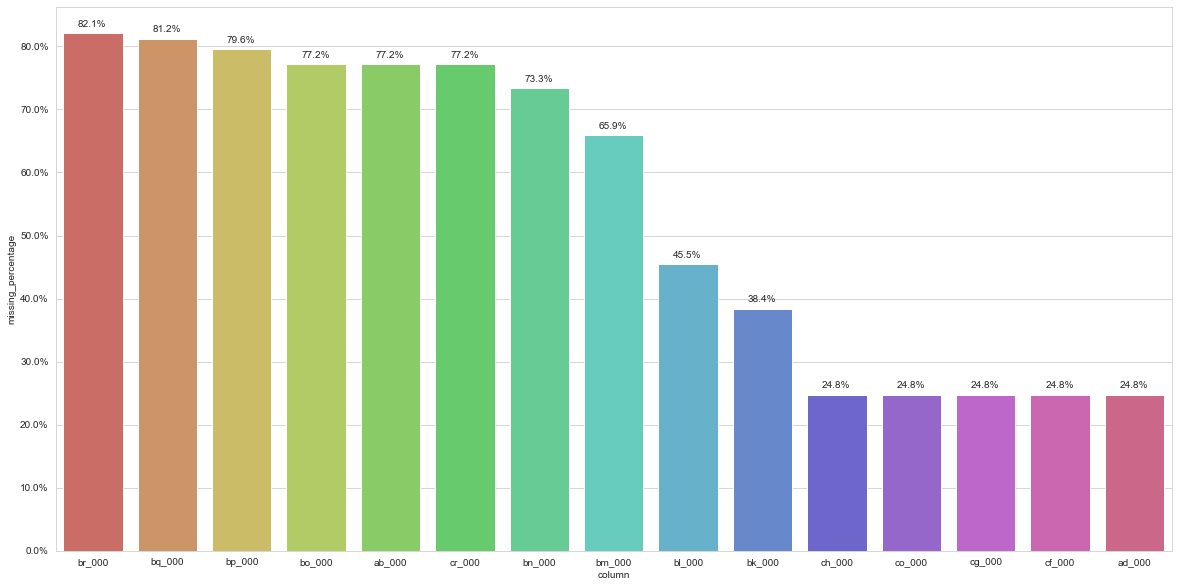

In [38]:
# Plotting a graph showing the top 15 features having highest percentage of missing values 
sns.set_style(style="whitegrid")
plt.figure(figsize=(20,10))

# Bar Plot
plot = sns.barplot(x= count_nan['column'][:15], y = count_nan['missing_percentage'][:15], palette="hls")

# Add annotations above each bar signifying their value
for p in plot.patches:
        plot.annotate('{:.1f}%'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+1))

# Make y-axis more interpretable
plot.set_yticklabels(map('{:.1f}%'.format, plot.yaxis.get_majorticklocs())) 
plt.show()

## 1.4 Fill NA

* Estratégia ciclo 1:
    - Retirar do dataset as colunas com mais de 60% de valores faltantes
    - Preencher os demais valores faltantes com a média ou alguma técnica de imputação(MICE, KNNImputer, SoftImpute)

In [28]:
# tirando as colunas com mais de 60% de dados faltantes
dropped = list(count_nan.loc[count_nan['missing_percentage'] > 60,'column'])
df1.drop(columns = dropped, inplace = True)
df_validation = df_validation.drop( columns = dropped, inplace = True )
print('Colunas retiradas do conjunto de dados:\n{}'.format( dropped ) )

Colunas retiradas do conjunto de dados:
[]


In [29]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df1_imp_mean =  pd.DataFrame( imp_mean.fit_transform( df1.values ), columns=df1.columns )
df1 = df1_imp_mean.copy()

AttributeError: 'NoneType' object has no attribute 'values'

In [20]:
df1.isna().sum()

class     0
aa_000    0
ac_000    0
ad_000    0
ae_000    0
af_000    0
ag_000    0
ag_001    0
ag_002    0
ag_003    0
ag_004    0
ag_005    0
ag_006    0
ag_007    0
ag_008    0
ag_009    0
ah_000    0
ai_000    0
aj_000    0
ak_000    0
al_000    0
am_0      0
an_000    0
ao_000    0
ap_000    0
aq_000    0
ar_000    0
as_000    0
at_000    0
au_000    0
av_000    0
ax_000    0
ay_000    0
ay_001    0
ay_002    0
ay_003    0
ay_004    0
ay_005    0
ay_006    0
ay_007    0
ay_008    0
ay_009    0
az_000    0
az_001    0
az_002    0
az_003    0
az_004    0
az_005    0
az_006    0
az_007    0
az_008    0
az_009    0
ba_000    0
ba_001    0
ba_002    0
ba_003    0
ba_004    0
ba_005    0
ba_006    0
ba_007    0
ba_008    0
ba_009    0
bb_000    0
bc_000    0
bd_000    0
be_000    0
bf_000    0
bg_000    0
bh_000    0
bi_000    0
bj_000    0
bk_000    0
bl_000    0
bs_000    0
bt_000    0
bu_000    0
bv_000    0
bx_000    0
by_000    0
bz_000    0
ca_000    0
cb_000    0
cc_000    0
cd_0

# 2.0 DATA PREPARATION

In [30]:
df2 = df1.copy()

## 2.1 Feature Selection

In [31]:
# Separando os dados para treinar o modelo de seleção de features
X = df2.drop( 'class', axis=1 )
y = df2['class']

In [52]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# declaração
#rfe = RFE( estimator=RandomForestClassifier( n_estimators=100,max_depth=5,random_state=1 ),
#                         n_features_to_select=20,
#                         verbose=5 )
# Treino
#rfe.fit(X,y)

Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting estimator with 136 features.
F

RFE(estimator=RandomForestClassifier(max_depth=5, random_state=1),
    n_features_to_select=20, verbose=5)

In [54]:
feature_imp = dict( zip( X.columns,rfe.support_ ) )

In [57]:
feature_new = []
for k,v in feature_imp.items():
    if v== True:
        feature_new.append(k)

In [58]:
feature_new

['aa_000',
 'ag_001',
 'ag_002',
 'ag_003',
 'al_000',
 'am_0',
 'aq_000',
 'ay_005',
 'ay_006',
 'ay_008',
 'bb_000',
 'bj_000',
 'bt_000',
 'ci_000',
 'ck_000',
 'cn_000',
 'cn_004',
 'dn_000',
 'ee_005',
 'ee_007']

In [32]:
feature_new = ['aa_000', 'ag_001', 'ag_002', 'ag_003', 'al_000', 'am_0', 'aq_000', 'ay_005', 'ay_006', 'ay_008', 'bb_000', 'bj_000',
 'bt_000', 'ci_000', 'ck_000', 'cn_000', 'cn_004', 'dn_000', 'ee_005', 'ee_007']

In [33]:
df21 = df2[feature_new]
df21['class'] = df2['class']

In [16]:
df21.head()

,aa_000,ag_001,ag_002,ag_003,al_000,am_0,aq_000,ay_005,ay_006,ay_008,bb_000,bj_000,bt_000,ci_000,ck_000,cn_000,cn_004,dn_000,ee_005,ee_007,class
0,76698.0,0.0,0.0,0.0,0.0,0.0,1132040.0,469014.0,4239660.0,755876.0,6700214.0,799478.0,76698.08,5245752.00,916567.68,0.0,1309472.0,62282.0,469792.0,157956.0,0.0
1,33058.0,0.0,0.0,0.0,0.0,0.0,338544.0,71510.0,772720.0,99560.0,3646660.0,392208.0,33057.51,2291079.36,643536.96,0.0,1179502.0,33736.0,245416.0,81140.0,0.0
2,41040.0,0.0,0.0,0.0,0.0,0.0,153698.0,0.0,870456.0,1450312.0,2673338.0,139730.0,41040.08,2322692.16,236099.52,0.0,1215280.0,13876.0,409564.0,158022.0,0.0
3,12.0,0.0,0.0,318.0,642.0,3894.0,1014.0,0.0,0.0,5596.0,21614.0,3090.0,12.69,2135.04,4525.44,0.0,2170.0,232.0,44.0,0.0,0.0
4,60874.0,0.0,0.0,0.0,0.0,0.0,551022.0,372236.0,2128914.0,584074.0,4289260.0,399410.0,60874.03,3565684.80,379111.68,0.0,2497104.0,44946.0,347188.0,311560.0,0.0


# 3.0 EDA

In [35]:
df3 = df21.copy()

## 3.1 Análise Univariada

### 3.1.1 Variavel Target

In [33]:
df3['class'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: class, dtype: float64

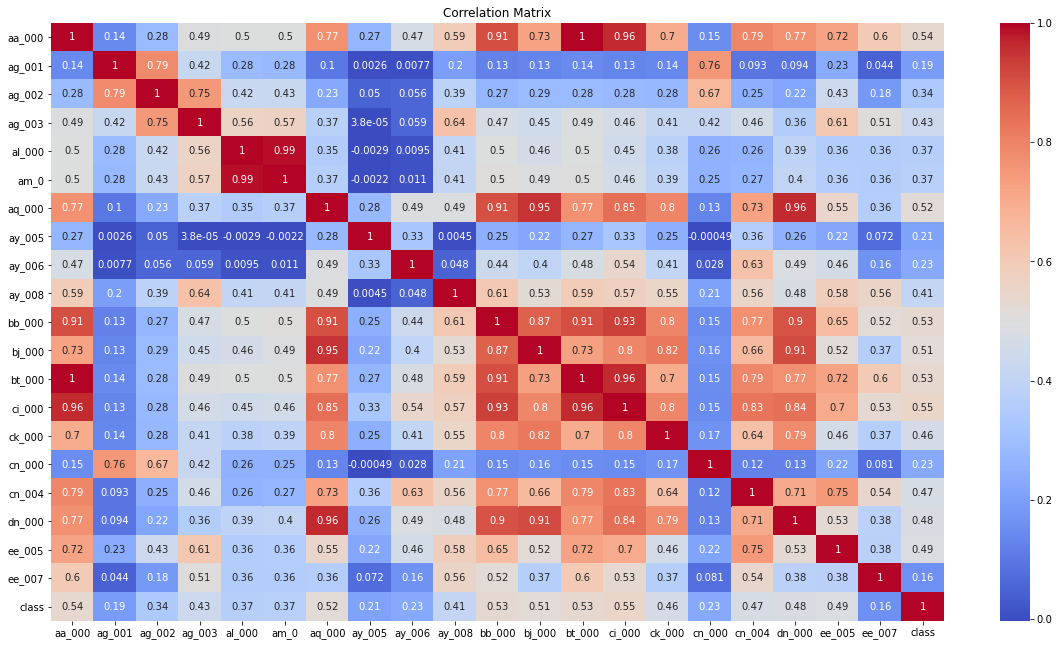

In [34]:
# Plot Correlation Heatmap      
plt.figure(figsize=(20,11))
sns.heatmap(df3.corr(),annot=True,cmap='coolwarm')
plt.title("Correlation Matrix")

plt.show()

### aa_000

 - Valores mais altos indicam falha no sistema de ar
 - A maioria dos valores não indicam falha

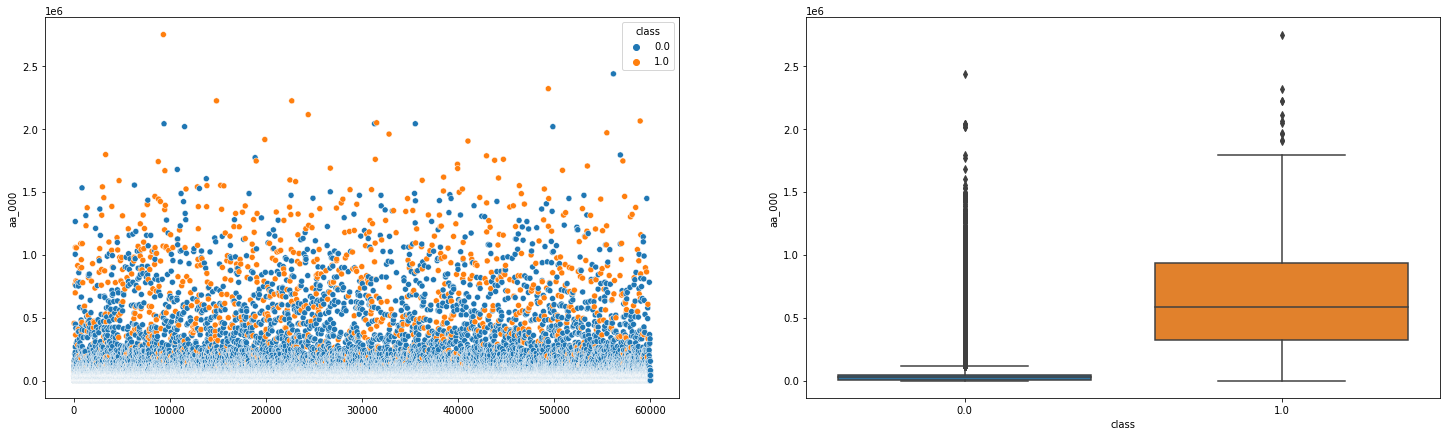

In [37]:
uni_analysis( df2, 'aa_000' );

### ag_001

 - Os valores mais altos da feature indicam falha

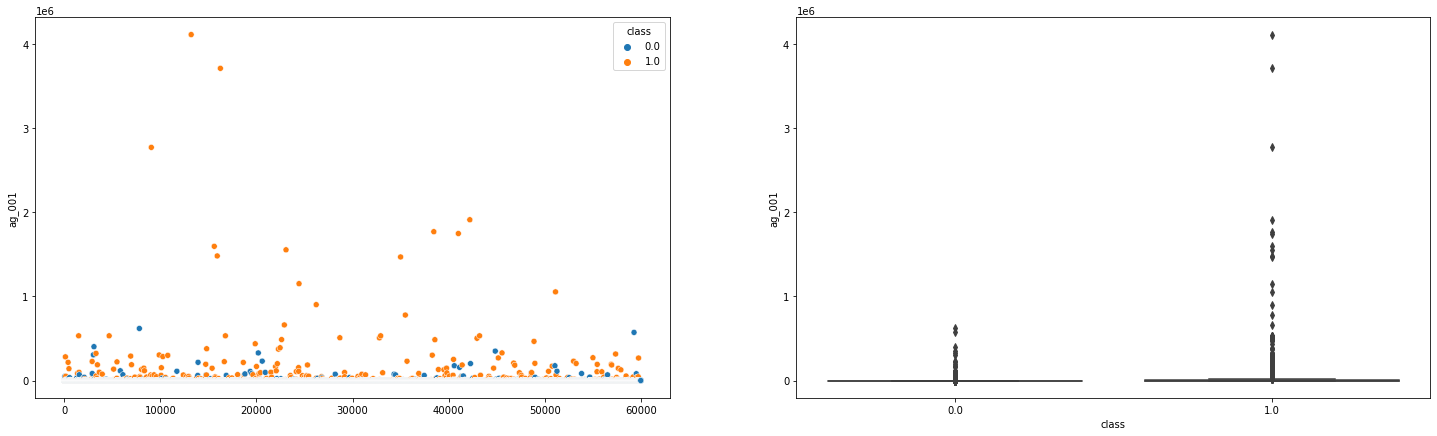

In [38]:
uni_analysis( df2, 'ag_001' );

### ag_002

 - Os valores mais altos da feature indicam falha

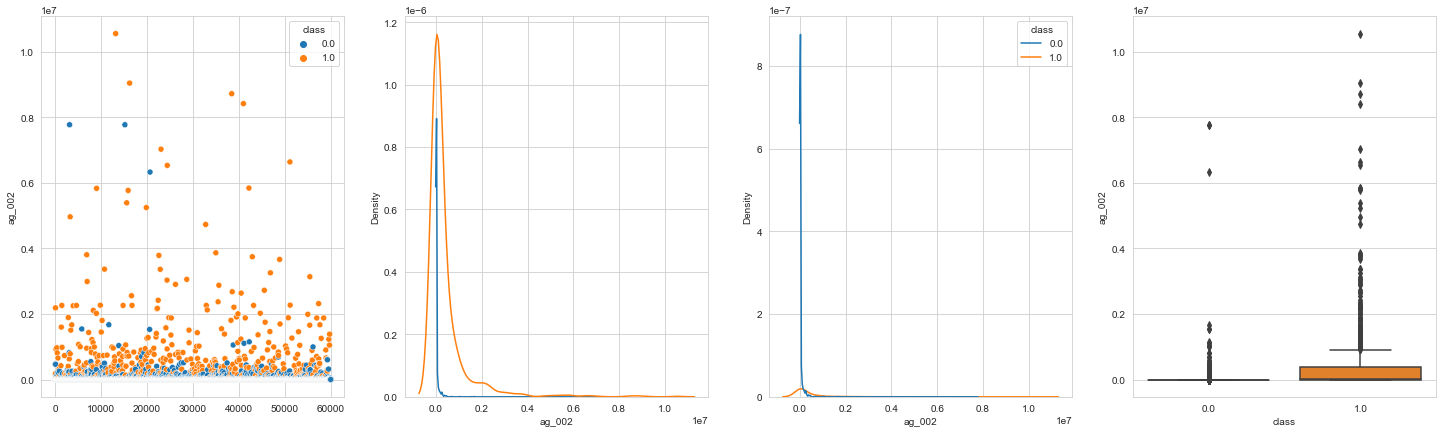

In [87]:
uni_analysis( df2, 'ag_002' );

### ag_003

 - Muitos valores zerados, remover a feature?

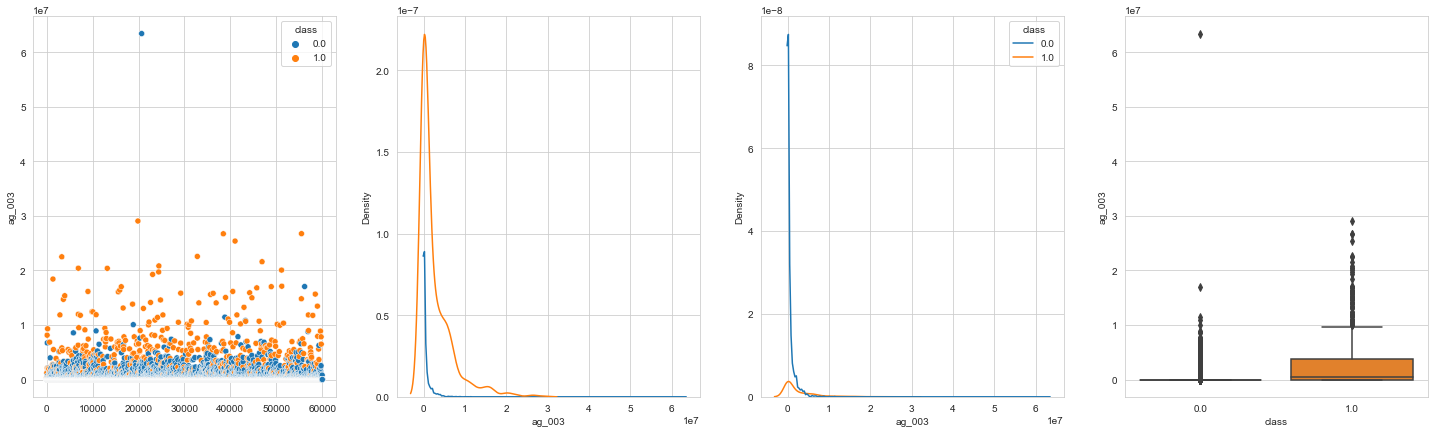

In [88]:
uni_analysis( df2, 'ag_003' );

### al_000

 - Maior incidencia de erros acontece em valores entre 1 e 1.5

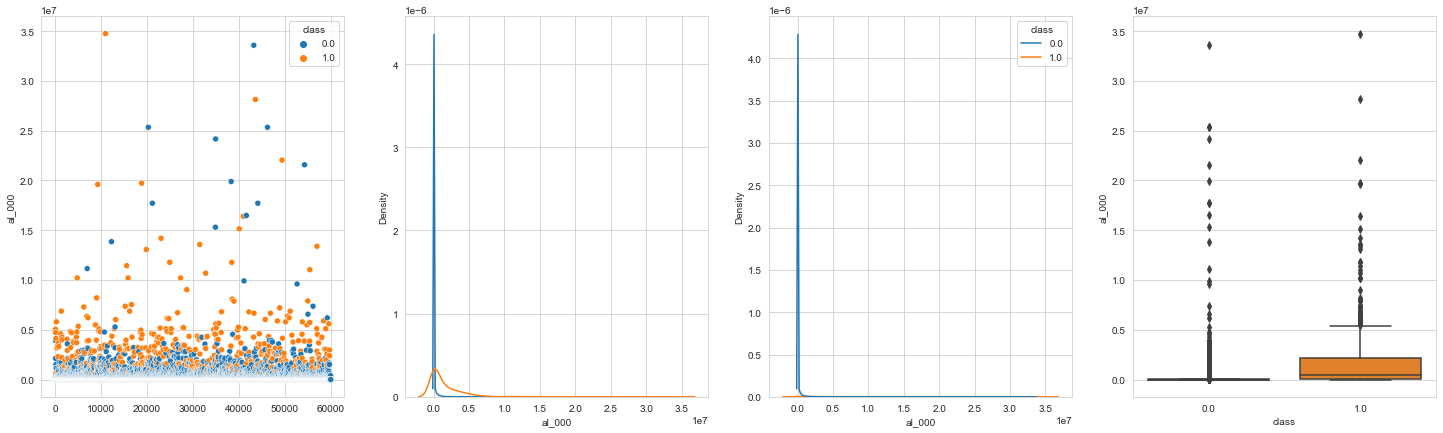

In [89]:
uni_analysis( df2, 'al_000' );

### am_0

 - O valor mais alto não indicou falha
 - Maior parte dos valores não indicam falha

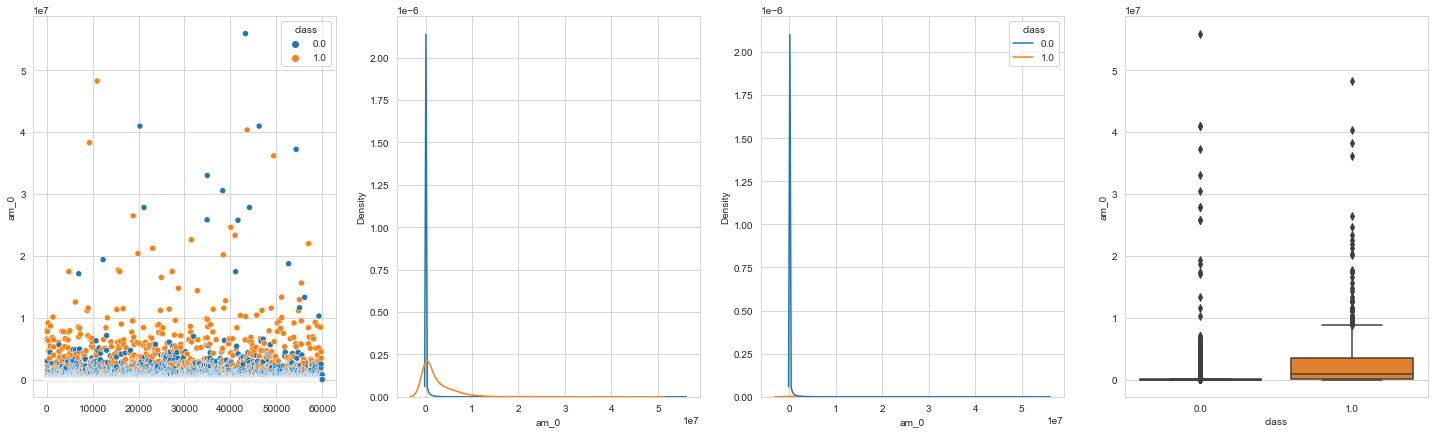

In [90]:
uni_analysis( df2, 'am_0' );

### aq_000

 - Existem muitos valores que indicam nenhuma falha de ar.

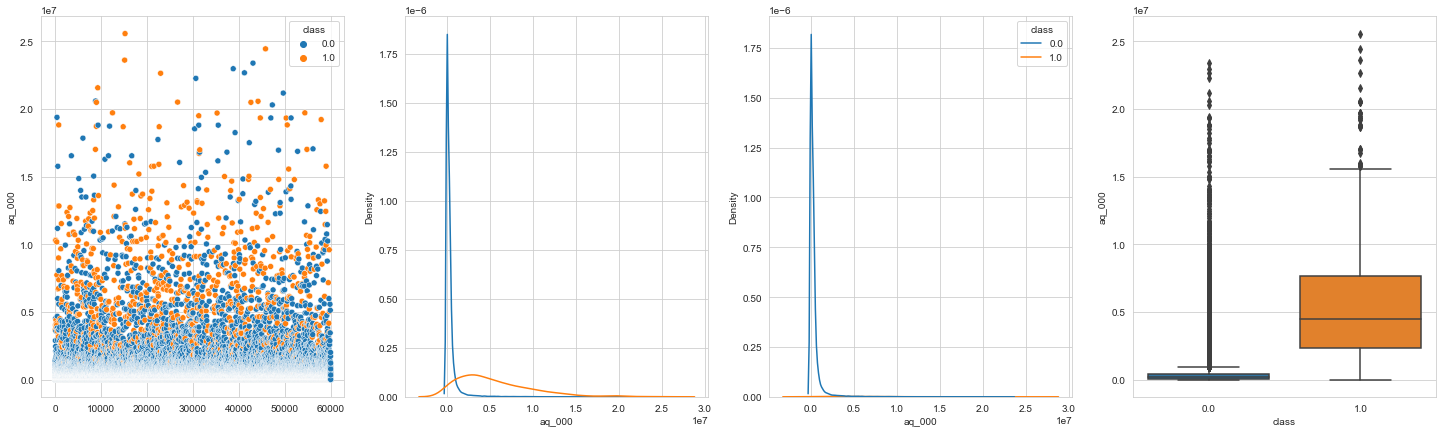

In [91]:
uni_analysis( df2, 'aq_000' );

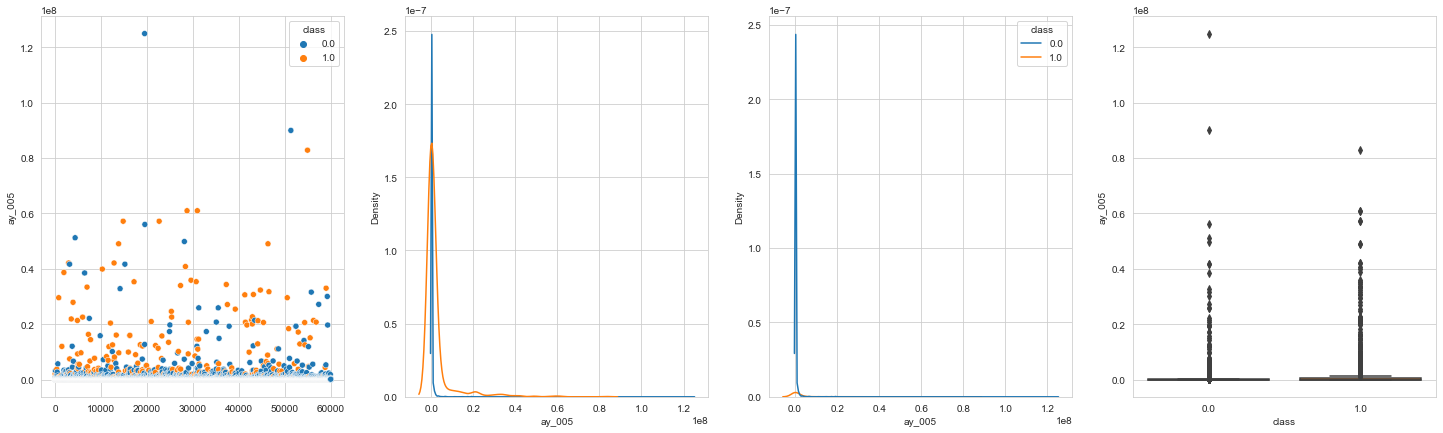

In [92]:
uni_analysis( df2, 'ay_005' );

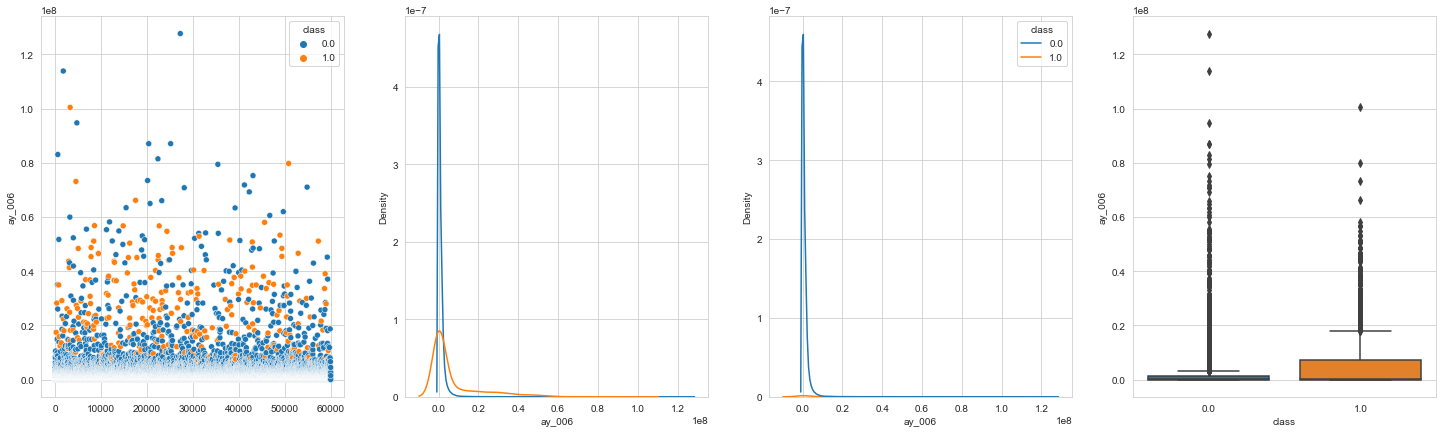

In [93]:
uni_analysis( df2, 'ay_006' );

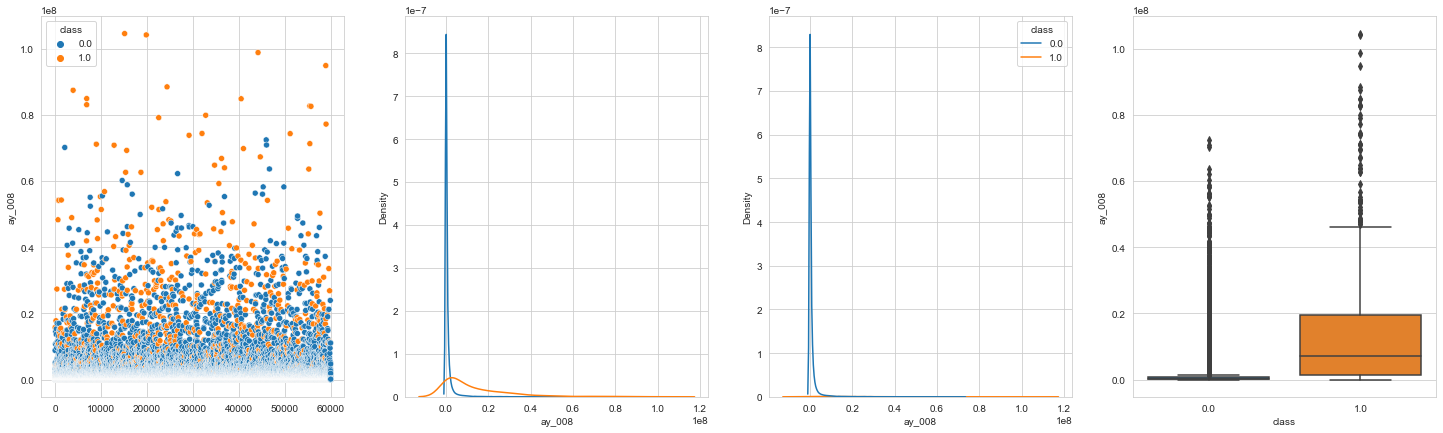

In [94]:
uni_analysis( df2, 'ay_008' );

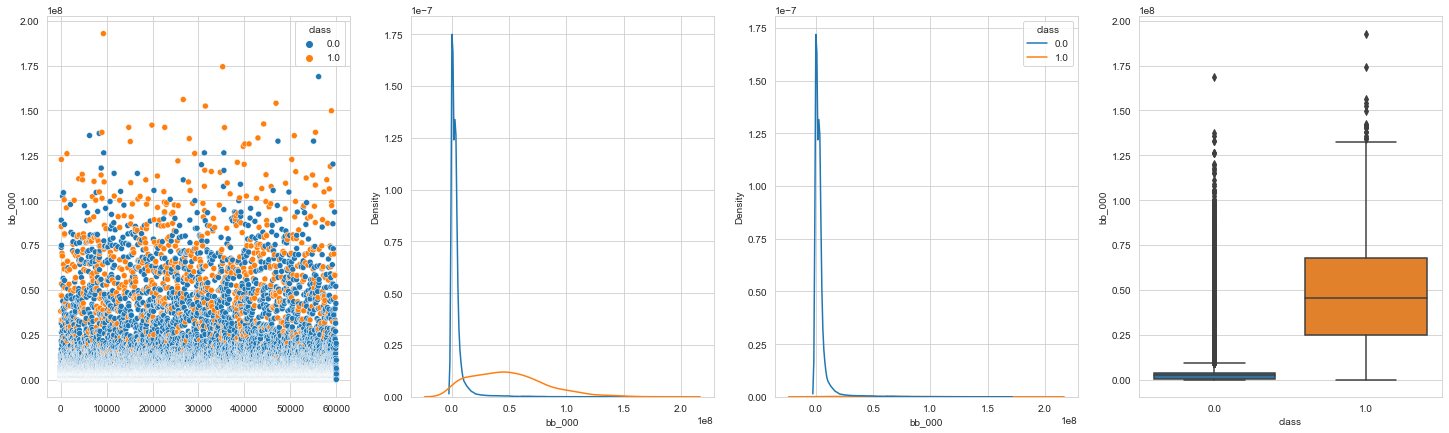

In [95]:
uni_analysis( df2, 'bb_000' );

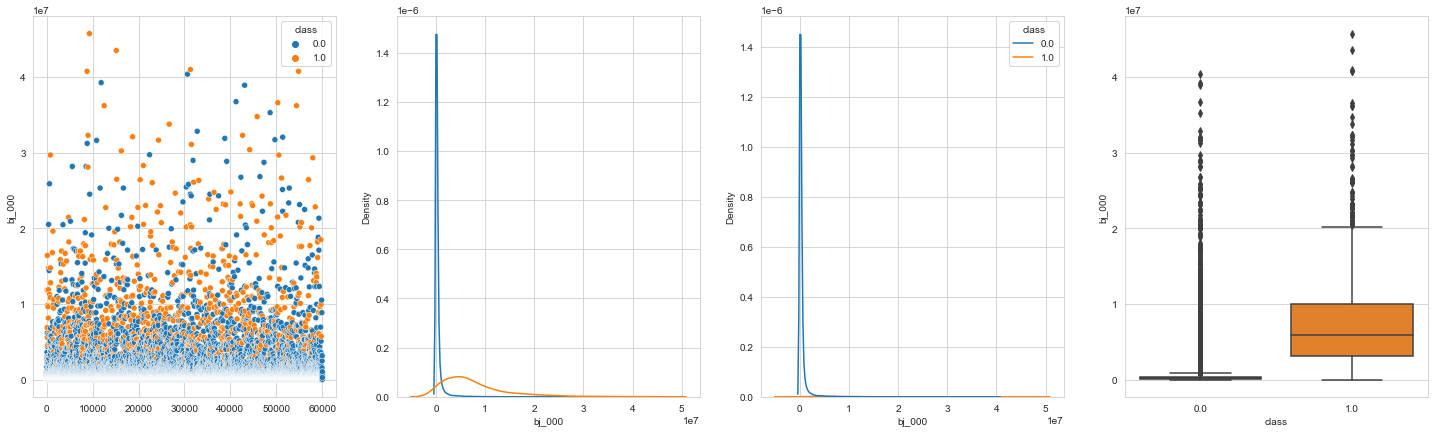

In [96]:
uni_analysis( df2, 'bj_000' );

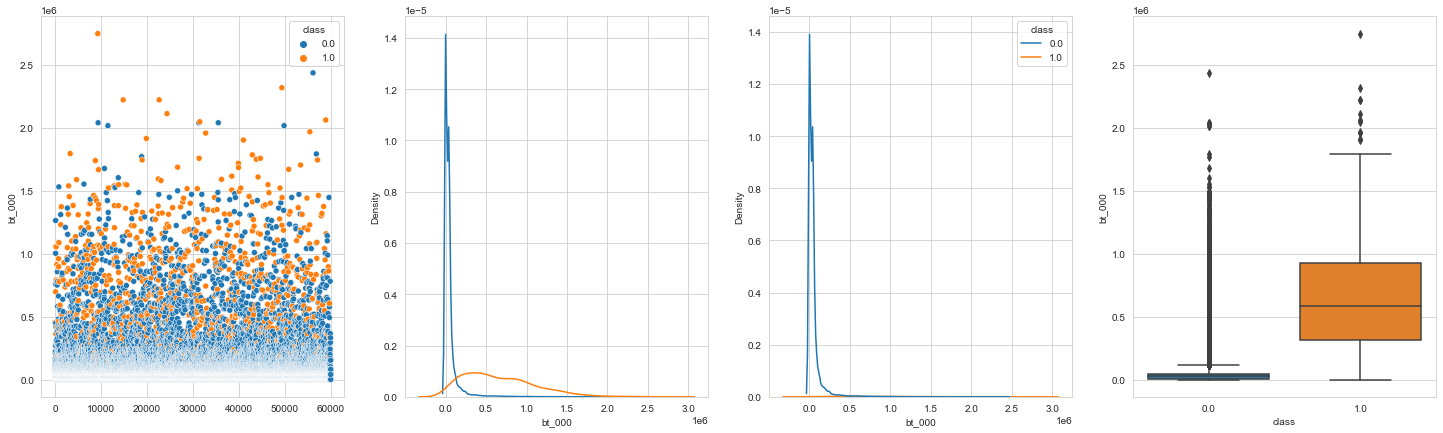

In [97]:
uni_analysis( df2, 'bt_000' );

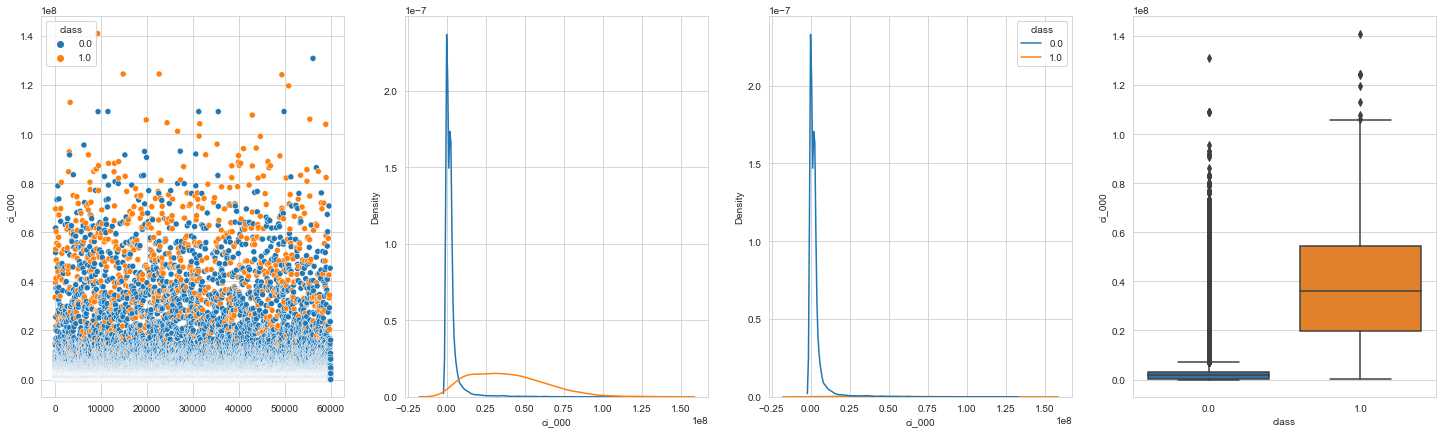

In [98]:
uni_analysis( df2, 'ci_000' );

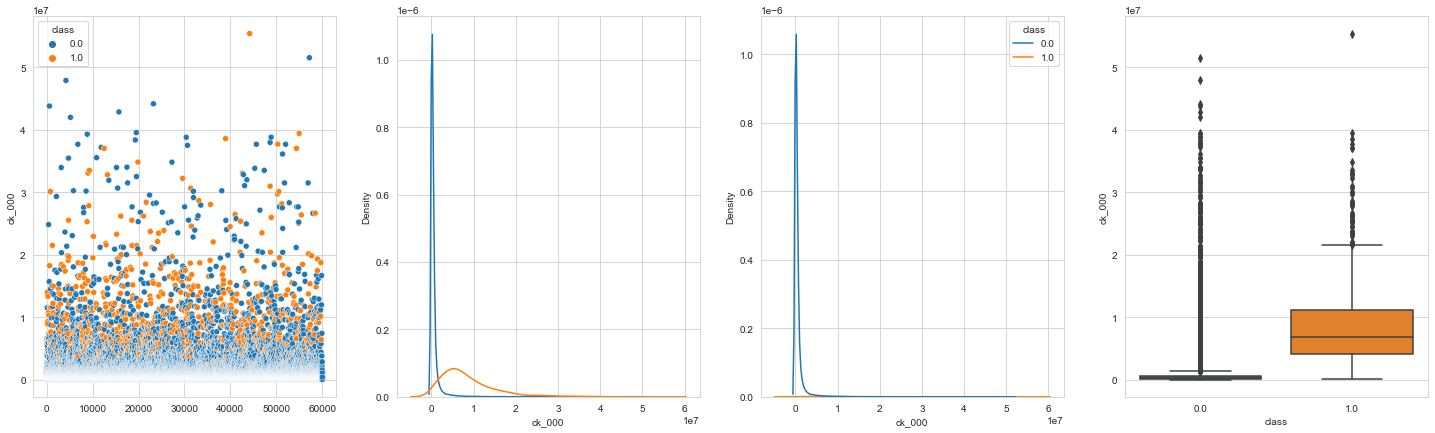

In [99]:
uni_analysis( df2, 'ck_000' );

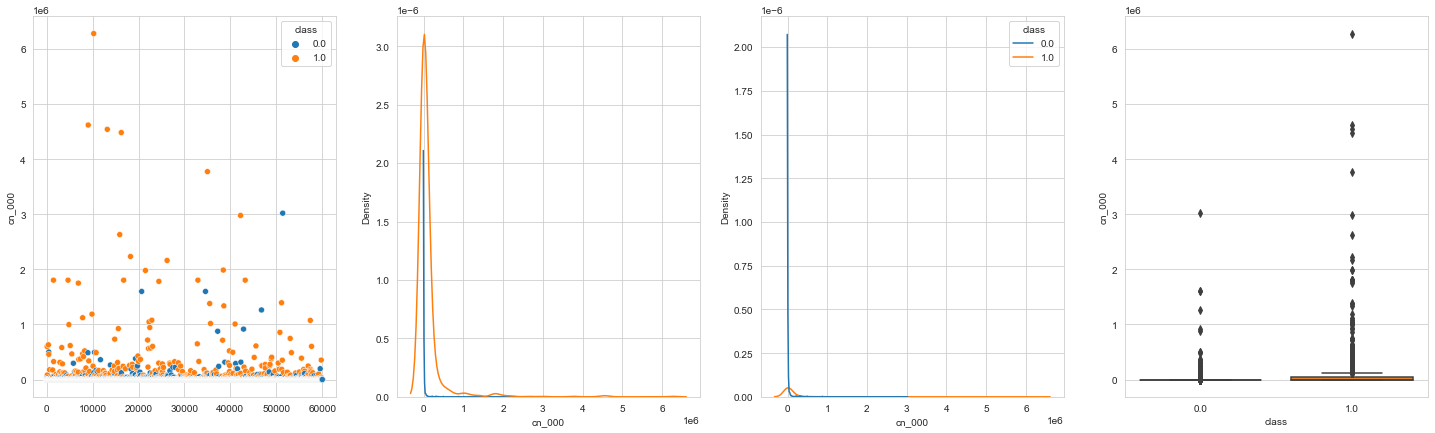

In [100]:
uni_analysis( df2, 'cn_000' );

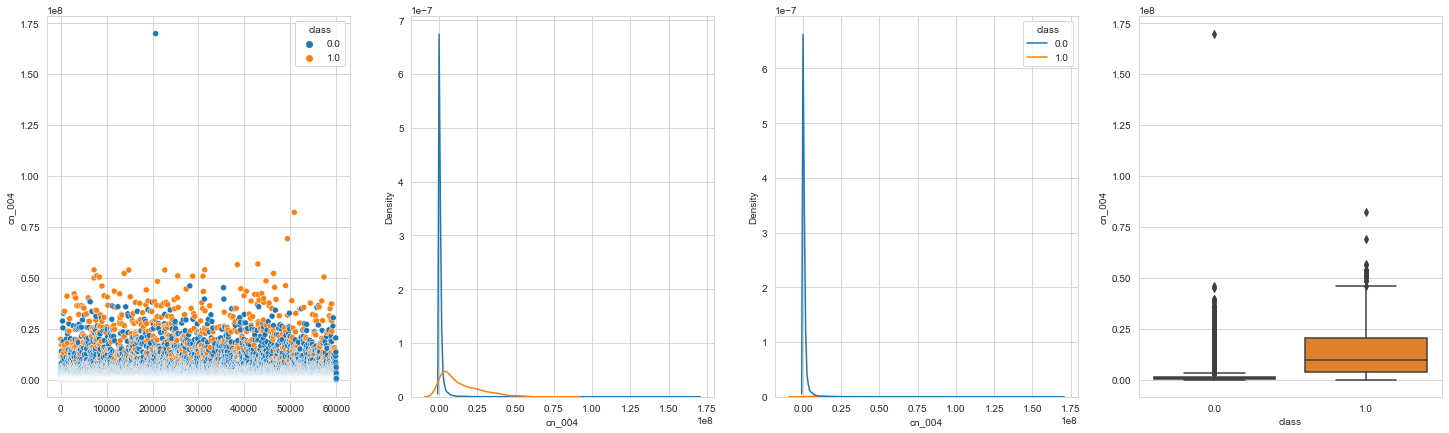

In [101]:
uni_analysis( df2, 'cn_004' );

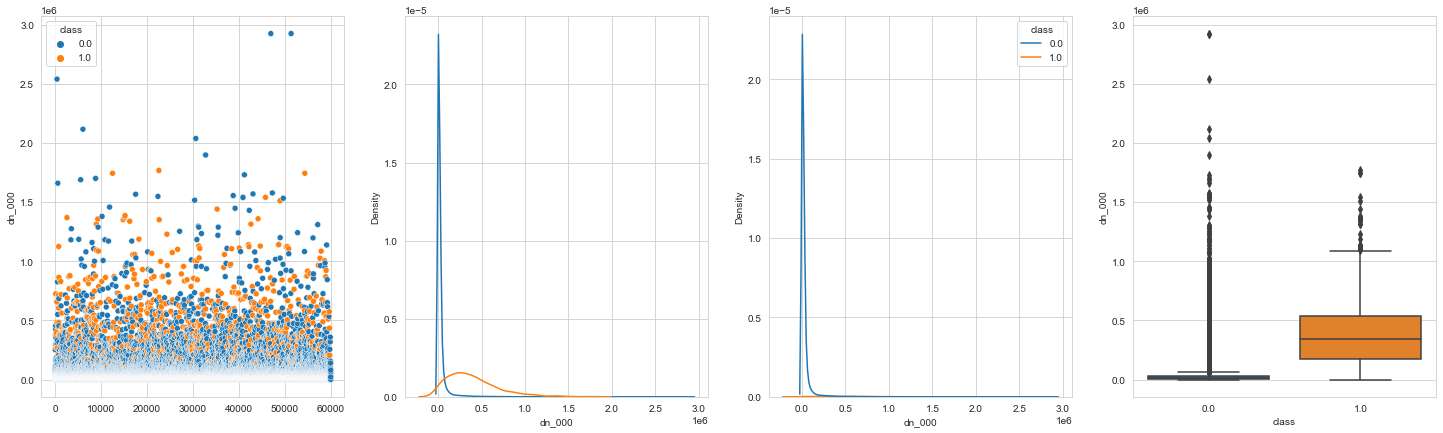

In [102]:
uni_analysis( df2, 'dn_000' );

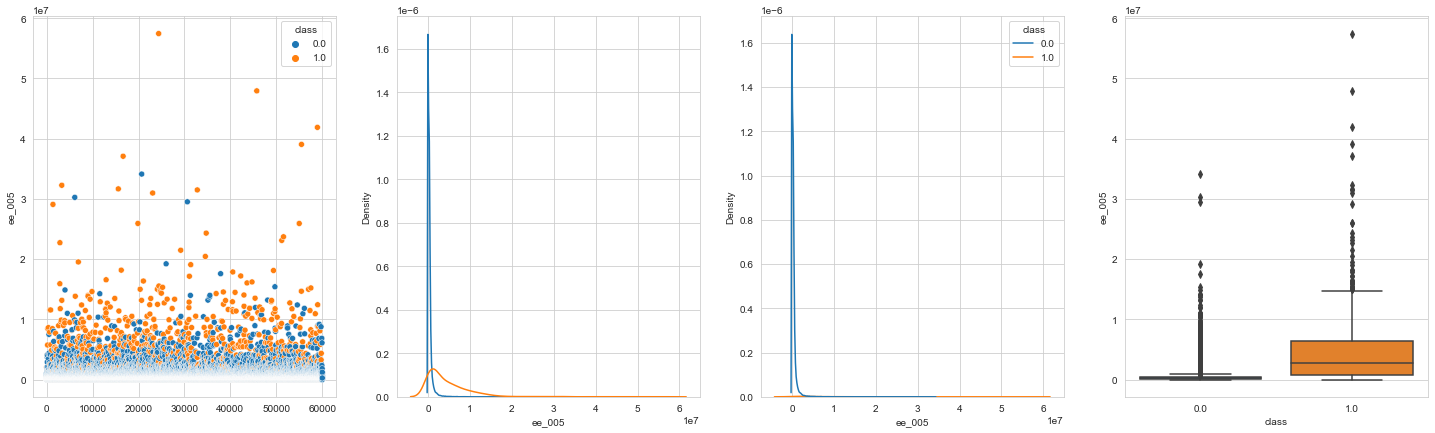

In [103]:
uni_analysis( df2, 'ee_005' );

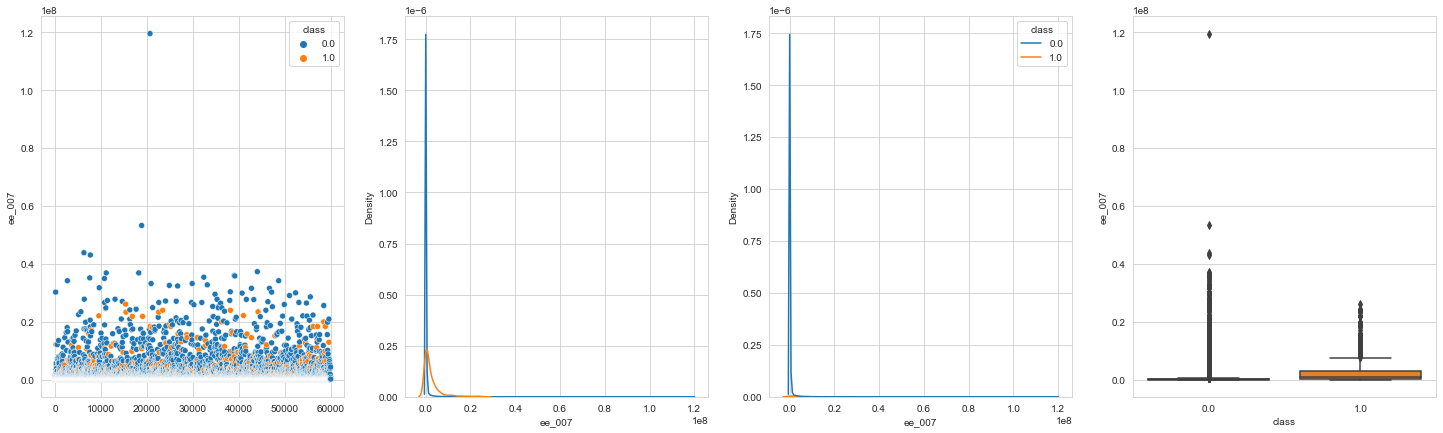

In [104]:
uni_analysis( df2, 'ee_007' );

## 3.2 Analise Bivariada

In [ ]:
sns.pairplot(df3, hue='class')

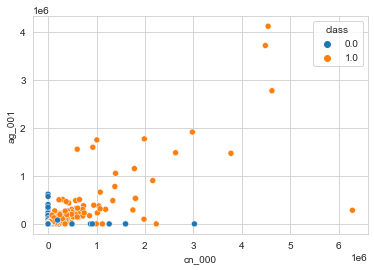

In [107]:
sns.scatterplot(df3["cn_000"],df3["ag_001"],hue=df3["class"]);

<AxesSubplot:xlabel='aa_000', ylabel='ag_001'>

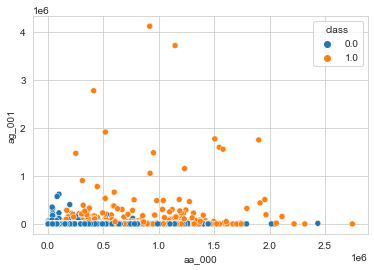

In [111]:
sns.scatterplot( df3["aa_000"], df3["ag_001"], hue=df3["class"] );

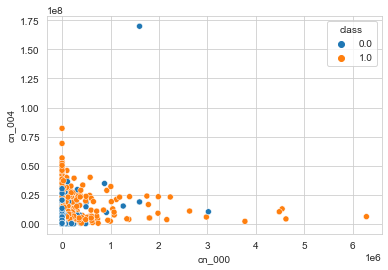

In [114]:
sns.scatterplot(df3["cn_000"],df3["cn_004"],hue=df3["class"]);

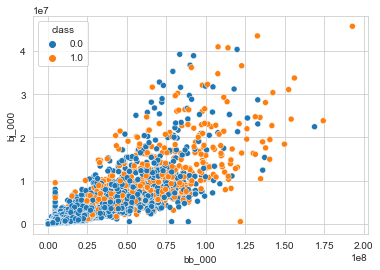

In [115]:
sns.scatterplot(df3["bb_000"],df3["bt_000"],hue=df3["class"]);

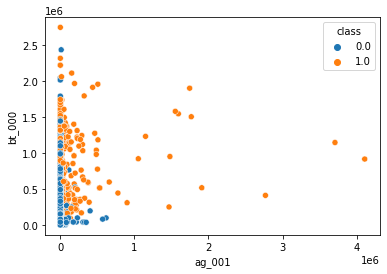

In [39]:
sns.scatterplot(df3["ag_001"],df3["bt_000"],hue=df3["class"]);

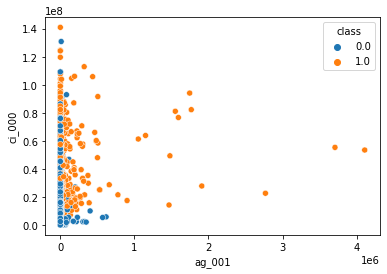

In [40]:
sns.scatterplot(df3["ag_001"],df3["ci_000"],hue=df3["class"]);

In [113]:
df3.columns

Index(['aa_000', 'ag_001', 'ag_002', 'ag_003', 'al_000', 'am_0', 'aq_000',
       'ay_005', 'ay_006', 'ay_008', 'bb_000', 'bj_000', 'bt_000', 'ci_000',
       'ck_000', 'cn_000', 'cn_004', 'dn_000', 'ee_005', 'ee_007', 'class'],
      dtype='object')

# 4.0 FEATURE ENGINEERING

In [47]:
df4 = df3.copy()

* Estratégia ciclo 1:

    - Criar novas features através da redução da dimensionalidade das atuais colunas do dataset

## 4.1 PCA

In [19]:
#from sklearn.decomposition import PCA
#pca = PCA( n_components=5 )
#new_features = pca.fit_transform( df4 )

In [20]:
# listas vazias para armazenar as novas features
#pca0 = []
#pca1 = []
#pca2 = []
#pca3 = []
#pca4 = []
#
## adicionando os dados nas listas vazias
#
#for i in range( len(new_features) ):
#    pca0.append( new_features[i][0] )
#    pca1.append( new_features[i][1] )
#    pca2.append( new_features[i][2] )
#    pca3.append( new_features[i][3] )
#    pca4.append( new_features[i][4] )   

In [21]:
## concatenando o df4 com as novas features
#df4['pca_1'] = pd.DataFrame(pca0)
#df4['pca_2'] = pd.DataFrame(pca1)
#df4['pca_3'] = pd.DataFrame(pca2)
#df4['pca_4'] = pd.DataFrame(pca3)
#df4['pca_5'] = pd.DataFrame(pca4)

In [22]:
df4.head()

,aa_000,ag_001,ag_002,ag_003,al_000,am_0,aq_000,ay_005,ay_006,ay_008,bb_000,bj_000,bt_000,ci_000,ck_000,cn_000,cn_004,dn_000,ee_005,ee_007,class,pca_1,pca_2,pca_3,pca_4,pca_5
0,76698.0,0.0,0.0,0.0,0.0,0.0,1132040.0,469014.0,4239660.0,755876.0,6700214.0,799478.0,76698.08,5245752.00,916567.68,0.0,1309472.0,62282.0,469792.0,157956.0,0.0,3.038600e+06,2.389613e+06,41131.911936,1.140978e+06,-897558.815681
1,33058.0,0.0,0.0,0.0,0.0,0.0,338544.0,71510.0,772720.0,99560.0,3646660.0,392208.0,33057.51,2291079.36,643536.96,0.0,1179502.0,33736.0,245416.0,81140.0,0.0,-1.613654e+06,2.853548e+05,-623935.989513,1.771803e+05,204856.727371
2,41040.0,0.0,0.0,0.0,0.0,0.0,153698.0,0.0,870456.0,1450312.0,2673338.0,139730.0,41040.08,2322692.16,236099.52,0.0,1215280.0,13876.0,409564.0,158022.0,0.0,-2.145870e+06,-3.522701e+05,795445.267244,1.065760e+05,56607.309339
3,12.0,0.0,0.0,318.0,642.0,3894.0,1014.0,0.0,0.0,5596.0,21614.0,3090.0,12.69,2135.04,4525.44,0.0,2170.0,232.0,44.0,0.0,0.0,-6.111422e+06,-3.106443e+05,-177330.808241,-1.695422e+05,10826.832732
4,60874.0,0.0,0.0,0.0,0.0,0.0,551022.0,372236.0,2128914.0,584074.0,4289260.0,399410.0,60874.03,3565684.80,379111.68,0.0,2497104.0,44946.0,347188.0,311560.0,0.0,9.551757e+04,1.314056e+06,667230.643400,5.650108e+05,571322.938943


## 4.2 SMOTE

In [29]:
df4.shape

(60000, 21)

In [49]:
X = df4.drop( 'class', axis = 1 )
y = df4['class'].copy()

In [50]:
from sklearn.preprocessing import MinMaxScaler

In [44]:
X_train_scale,scaler = scale_data(X)
pickle.dump( min_max, open('../parameters/min_max.pkl', 'wb') )

In [46]:
X_train_scale.head()

,aa_000,ag_001,ag_002,ag_003,al_000,am_0,aq_000,ay_005,ay_006,ay_008,bb_000,bj_000,bt_000,ci_000,ck_000,cn_000,cn_004,dn_000,ee_005,ee_007
0,0.027925,0.0,0.0,0.000000,0.000000,0.00000,0.044285,0.003754,0.033205,0.007229,0.034739,0.017480,0.027925,0.037208,0.016536,0.0,0.007709,0.021296,8.179508e-03,0.001321
1,0.012036,0.0,0.0,0.000000,0.000000,0.00000,0.013244,0.000572,0.006052,0.000952,0.018907,0.008575,0.012036,0.016250,0.011610,0.0,0.006944,0.011535,4.272917e-03,0.000679
2,0.014942,0.0,0.0,0.000000,0.000000,0.00000,0.006013,0.000000,0.006817,0.013870,0.013861,0.003055,0.014942,0.016475,0.004260,0.0,0.007154,0.004745,7.130884e-03,0.001321
3,0.000004,0.0,0.0,0.000005,0.000018,0.00007,0.000040,0.000000,0.000000,0.000054,0.000112,0.000068,0.000005,0.000015,0.000082,0.0,0.000013,0.000079,7.660803e-07,0.000000
4,0.022164,0.0,0.0,0.000000,0.000000,0.00000,0.021556,0.002979,0.016674,0.005586,0.022239,0.008733,0.022164,0.025291,0.006840,0.0,0.014700,0.015368,6.044861e-03,0.002605


In [51]:
# Separando o dataset em treino 80% e teste 20%
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [52]:
from imblearn.combine import SMOTETomek 

In [54]:
resampler = SMOTETomek(random_state=42, n_jobs=-1)

# resample the dataset
x_train_balanced, y_train_balanced = resampler.fit_resample(x_train, y_train)

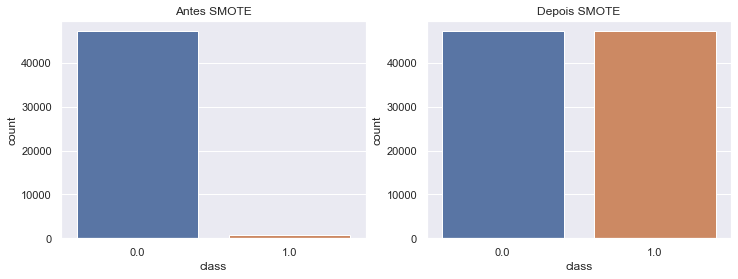

In [46]:
# plots before and after SMOTETomek
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(x=y_train)
plt.title("Antes SMOTE")

plt.subplot(1,2,2)
sns.countplot(x=y_train_balanced)
plt.title("Depois SMOTE")

plt.show()

In [56]:
X_train_scale,scaler = scale_data(x_train_balanced)

In [57]:
X_test_scale = pd.DataFrame(data = scaler.transform(x_test) , columns=x_test.columns)

In [58]:
print(X_train_scale.shape,X_test_scale.shape)

(94408, 20) (12000, 20)


# 5.0 MACHINE LEARNING MODELING

## 5.1.1 Logistic Regression

In [71]:
# model
lr = LogisticRegression(random_state=42).fit( X_train_scale, y_train_balanced )

# predict
yhat_logistic = lr.predict( X_test_scale )

# performance
lr_result = scores( 'Logistic Regression', y_test, yhat_logistic )
lr_result

,Accuracy,Precision,recall,macro_f1,roc_auc
Logistic Regression,0.964667,0.320339,0.891509,0.726522,0.928746


In [48]:
# model
lr = LogisticRegression(random_state=42).fit( x_train_balanced, y_train_balanced )

# predict
yhat_logistic = lr.predict( x_test )

# performance
lr_result = scores( 'Logistic Regression', y_test, yhat_logistic )
lr_result

,Accuracy,Precision,recall,macro_f1,roc_auc
Logistic Regression,0.968917,0.350093,0.886792,0.74298,0.928593


In [60]:
from sklearn.linear_model  import LogisticRegression

False Positive:  347
False Negative: 24
Total cost:  15470


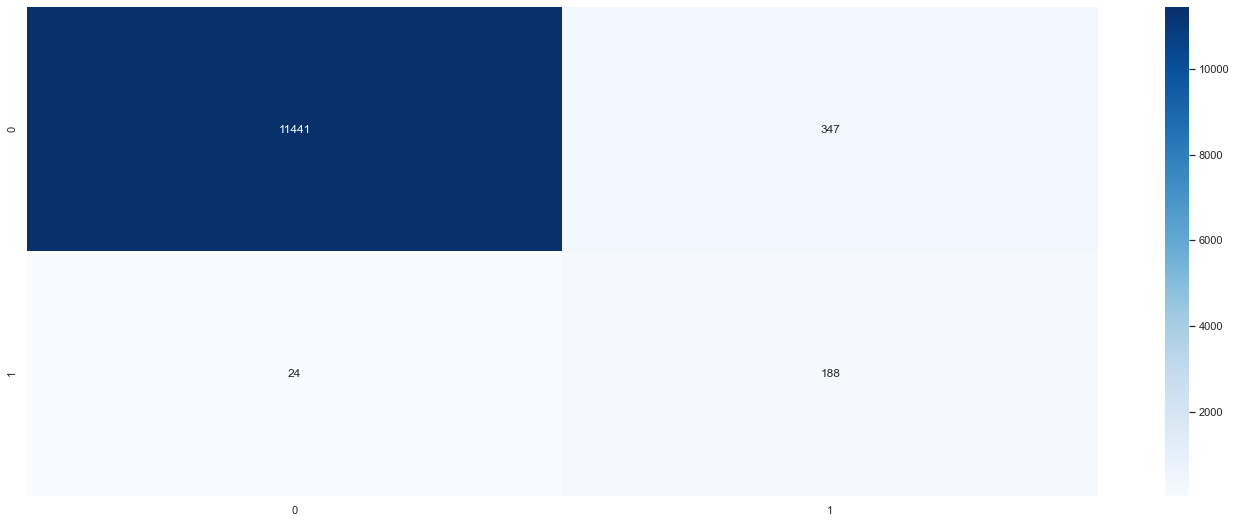

In [33]:
plot_confusion_matrix(y_test, yhat_logistic)

## 5.1.2 Random Forest

In [36]:
# model
rf = RandomForestClassifier( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train_balanced, y_train_balanced )

# predict
yhat_rf = rf.predict( x_test )


# performance
rf_result = scores( 'Random Forest', y_test, yhat_rf )
rf_result

,Accuracy,Precision,recall,macro_f1,roc_auc
Random Forest,0.98925,0.662745,0.79717,0.859144,0.894937


False Positive:  86
False Negative: 43
Total cost:  22360


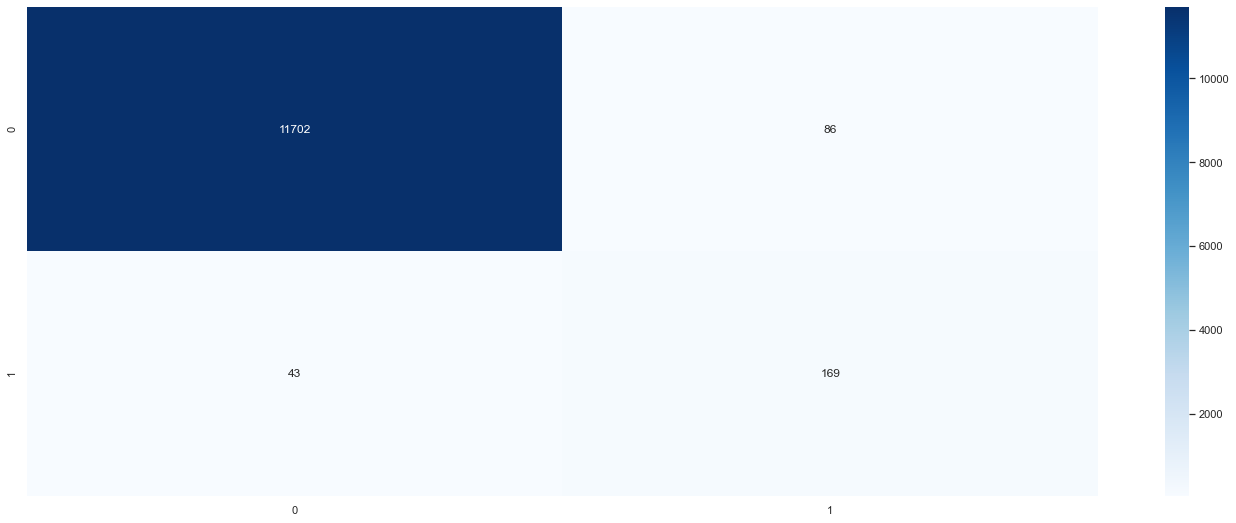

In [37]:
plot_confusion_matrix(y_test, yhat_rf)

In [35]:
from sklearn.ensemble import RandomForestClassifier

## 5.1.3 XGBoost

In [60]:
from xgboost import XGBClassifier

In [66]:
# model
model_xgb = XGBClassifier(random_state=42, n_jobs=-1).fit( x_train_balanced, y_train_balanced )

# predict
yhat_xgb= model_xgb.predict( x_test )


# performance
xgb_result = scores( 'XGBoost Classifier', y_test, yhat_xgb )
xgb_result

,Accuracy,Precision,recall,macro_f1,roc_auc
XGBoost Classifier,0.94075,0.223085,0.948113,0.66506,0.944365


In [61]:
# model
model_xgb = XGBClassifier(random_state=42, n_jobs=-1).fit( X_train_scale, y_train_balanced )

# predict
yhat_xgb= model_xgb.predict( X_test_scale )


# performance
xgb_result = scores( 'XGBoost Classifier', y_test, yhat_xgb )
xgb_result

,Accuracy,Precision,recall,macro_f1,roc_auc
XGBoost Classifier,0.968667,0.351449,0.915094,0.745836,0.942362


In [ ]:
print(X_train_scale.shape,X_test_scale.shape)

False Positive:  358
False Negative: 18
Total cost:  12580


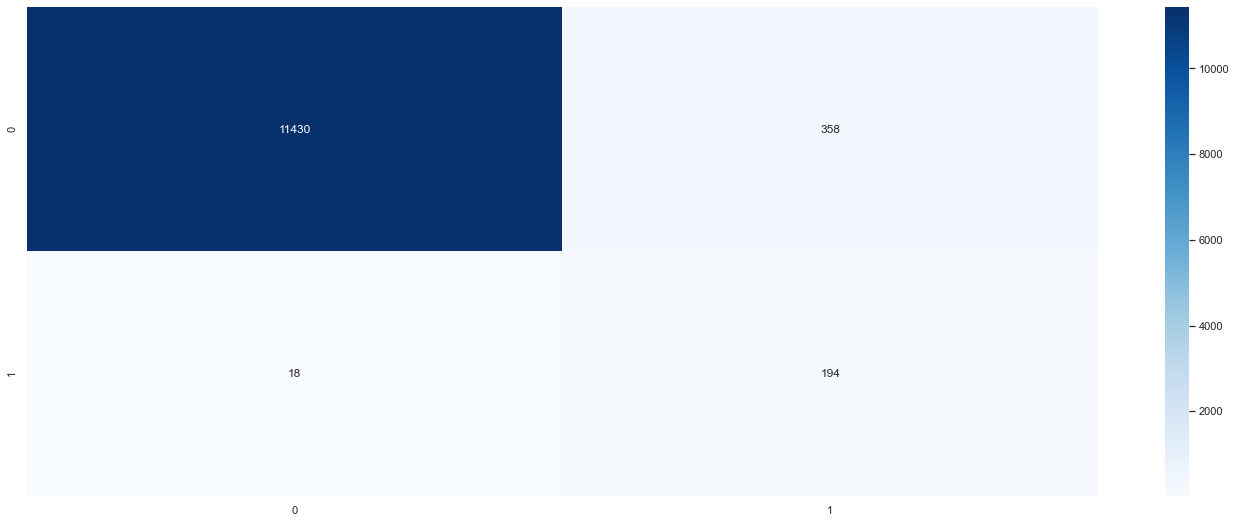

In [64]:
plot_confusion_matrix(y_test, yhat_xgb)

In [67]:
# Save Trained Model
pickle.dump( model_xgb, open('../models/xgb_2.pkl', 'wb') )
model_xgb

XGBClassifier(n_jobs=-1, random_state=42)

## 5.1.4 SVM

In [41]:
from sklearn.svm import SVC

In [42]:
# model
model_svm = SVC( random_state=42 ).fit( x_train_balanced, y_train_balanced )

# predict
yhat_svm = model_svm.predict( x_test )

# performance
svm_result = scores( 'SVM', y_test, yhat_svm )
svm_result

,Accuracy,Precision,recall,macro_f1,roc_auc
SVM,0.96525,0.325383,0.900943,0.730062,0.933675


False Positive:  396
False Negative: 21
Total cost:  14460


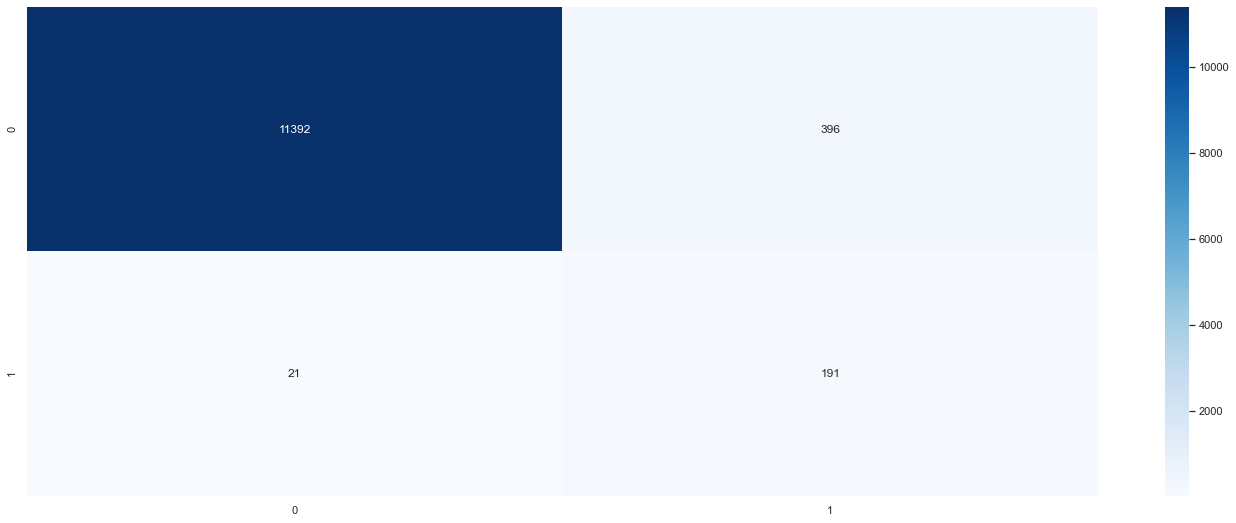

In [43]:
plot_confusion_matrix(y_test, yhat_svm)

## 5.2 Model Comparing

In [55]:
results = pd.concat( [lr_result, rf_result, svm_result, xgb_result] ).sort_values( 'macro_f1', ascending=False )
results

,Accuracy,Precision,recall,macro_f1,roc_auc
Random Forest,0.989250,0.662745,0.797170,0.859144,0.894937
Logistic Regression,0.969083,0.351402,0.886792,0.743696,0.928678
SVM,0.965250,0.325383,0.900943,0.730062,0.933675
XGBoost Classifier,0.940750,0.223085,0.948113,0.665060,0.944365


## 5.2.1 CrossValidation

In [90]:
# logistic Regression CV
lr_val = cross_val_score(lr, x_train_balanced, y_train_balanced, cv=5, scoring='f1_macro')
print( 'logistic Regression F1 Score:', round( np.mean(lr_val), 5), '+/-', round(np.std(lr_val), 5) )

# XGBoost CV
xgb_val = cross_val_score(model_xgb, x_train_balanced, y_train_balanced, cv=5, scoring='f1_macro' )
print( 'XGBoost F1 Score:', round( np.mean(xgb_val), 5), '+/-', round(np.std(xgb_val), 5) )

# Random Forest CV
rf_val = cross_val_score(rf, x_train_balanced, y_train_balanced, cv=5, scoring='f1_macro')
print( 'Random Forest F1 Score:', round( np.mean(rf_val), 5), '+/-', round(np.std(rf_val), 5) )

# SVM CV
svm_val = cross_val_score(model_svm, x_train_balanced, y_train_balanced, cv=5, scoring='f1_macro')
print( 'SVM F1 Score:', round( np.mean(svm_val), 5), '+/-', round(np.std(svm_val), 5) )

logistic Regression 0.95174 +/- 0.00129
XGBoost 0.96394 +/- 0.00192
Random Forest 0.99538 +/- 0.00048
SVM 0.96391 +/- 0.00131


In [ ]:
xgb_tuned = XGBClassifier(n_jobs= -1,random_state=42,max_depth=10,n_estimators= 200)

## 5.3 Hyperparameter Fine Tuning

In [96]:
from sklearn.model_selection import GridSearchCV

In [98]:
params = {'n_estimators':[200,300,500],'max_depth':[3,5,10]}
clf=XGBClassifier()

model=GridSearchCV(clf,param_grid=params,n_jobs=-1,scoring='f1',cv=5)
model.fit(x_train_balanced, y_train_balanced)

GridSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10],
                         'n_estimators': [200, 300, 500]},
             scoring='f1')

In [99]:
print("Best estimator is", model.best_params_)

Best estimator is {'max_depth': 10, 'n_estimators': 200}


In [68]:
xgb_tuned = XGBClassifier(n_jobs= -1,random_state=42,max_depth=10,n_estimators= 200).fit( X_train_scale, y_train_balanced )


yhat_xgb_tuned = xgb_tuned.predict( X_test_scale )

xgb_tuned_result = scores( 'XGBoost Classifier', y_test, yhat_xgb_tuned )
xgb_tuned_result

,Accuracy,Precision,recall,macro_f1,roc_auc
XGBoost Classifier,0.988917,0.64794,0.816038,0.858342,0.904032


In [70]:
# Save Trained Model
pickle.dump( xgb_tuned, open('../models/xgb.pkl', 'wb') )

## 5.4 SHAP

In [78]:
X_frame = pd.DataFrame(data=X, columns=X.columns)

In [79]:
import shap

explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_frame)

## Features mais relevantes para o modelo

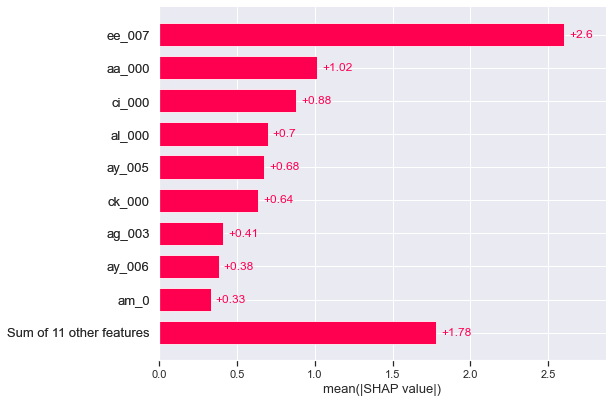

In [81]:
shap.plots.bar(shap_values)

# 6.0 DEPLOY

## 6.1 PmManutencao Class

In [ ]:
import pickle
import inflection
import pandas as pd

class PmManutencao( object ):

	def __init__( self ):
		self.home_path  =  '../parameters'
		self.min_max    = pickle.load( open( self.home_path + '/min_max.pkl', 'rb' ) )


	def data_cleaning( self, df1 ):

		df1.replace( 'na',np.nan,inplace = True )

		imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
		df1_imp_mean =  pd.DataFrame( imp_mean.fit_transform( df1.values ), columns=df1.columns )
		df1 = df1_imp_mean.copy()

		feature_new = ['aa_000', 'ag_001', 'ag_002', 'ag_003', 'al_000', 'am_0', 'aq_000', 'ay_005', 'ay_006', 'ay_008', 'bb_000', 'bj_000', 'bt_000', 'ci_000', 'ck_000', 'cn_000', 'cn_004', 'dn_000', 'ee_005', 'ee_007', 'class']

		df1 = df1[feature_new]

		df1 = pd.DataFrame( data = self.min_max.fit_transform(df1) , columns = df1.columns )

		return df1


	def get_prediction( self, model, original_data, test_data ):

		# prediction
		pred = model.predict( test_Data )

		# Join pred into original data
		original_data['pred'] = pred[:,1].tolist()

		return original_data.to_json( orient = 'records', data_format = 'iso' )

## 6.2 API Handler

In [ ]:
import pickle
import os
import pandas as pd
from flask                     import Flask, request, Response
from pmmanutencao.PmManutencao import PmManutencao

# loading model
model = pickle.load( open( 'models/xgb.pkl', 'rb' ) )


# initialize api
app = Flask( __name__ )

@app.route( '/predict', methods=['POST'] )
def pmmanutencao_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple examples
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instatiate PmManutencao Class
        pipeline = PmManutencao()
        
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )




if __name__ == '__main__':
    port = os.environ.get( 'PORT', 5000 )
    app.run( '127.0.0.1', port=port, debug=True )